# Chess Opening Recommender: Style Matching & Clustering

We will now take the per‑player style vectors (single user in this case) computed in the feature engineering notebook and find which elite players our target user most closely resembles. 

We will
1. Build a style database of reference (elite) players.  
3. Cluster elite players into style archetypes.  
4. Compute distances between the user’s vector and each elite player to identify top stylistic neighbors.



In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from tqdm import tqdm
from pathlib import Path
from typing import Optional

In [8]:
DATA_DIR = Path("/Users/nicholasvega/Downloads/chess-opening-recommender/data")
USER_STYLE_CSV = DATA_DIR / "Chessanonymous1_style_vector.csv"
ELITE_STYLE_CSV = DATA_DIR / "elite_style_vectors.csv"

In [9]:
user_style_df = pd.read_csv(USER_STYLE_CSV, index_col=0)    
user_style_series = user_style_df['value']                

elite_style_vectors = pd.read_csv(ELITE_STYLE_CSV)          

In [10]:
user_style_df

,value
avg_moves,78.543945
pct_long_games,0.418049
avg_trades,16.153666
avg_queen_move,19.997293
pct_castled_early,0.039416
avg_checks,5.149311
win_rate,0.535828
pct_wins,0.514531
pct_draws,0.042593
pct_losses,0.442876


In [11]:
elite_style_vectors

,player,avg_moves,pct_long_games,avg_trades,avg_queen_move,pct_castled_early,avg_checks,win_rate,pct_wins,pct_draws,pct_losses,queen_trade_freq,pct_games_endgame,opening_variety
0,eNErGyOFbEiNGbOT,136.996440,0.803318,21.172985,20.030806,0.304502,11.930095,0.498223,0.027251,0.941943,0.030806,0.232227,0.813981,0.120853
1,Chessanonymous1,82.669174,0.453634,17.383460,18.478697,0.035088,5.670426,0.536967,0.512531,0.048872,0.438597,0.080200,0.469925,0.035088
2,Kyreds_pet,134.287700,0.805104,20.967518,18.464037,0.457077,12.329467,0.515081,0.062645,0.904872,0.032483,0.310905,0.819025,0.120650
3,rtahmass,88.449210,0.546597,19.250261,18.491100,0.330890,6.361257,0.516754,0.461780,0.109948,0.428272,0.212565,0.568586,0.114136
4,CruelKen,135.004700,0.719875,20.596245,21.690142,0.660407,10.286385,0.531299,0.092332,0.877934,0.029734,0.154930,0.733959,0.106416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16227,fattal381,33.000000,0.000000,8.000000,22.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
16228,NicolaNigro,90.000000,1.000000,19.000000,18.000000,0.000000,8.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
16229,sezginonline,75.000000,0.000000,16.000000,28.000000,0.000000,7.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
16230,ZANOSY1,60.000000,0.000000,11.000000,19.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000


## Cluster Elite Style Vectors 

In [13]:
def cluster_styles(
    style_vectors: pd.DataFrame, n_clusters: int, random_state: int = 42
):
    feats = style_vectors.drop(columns=["player"], errors="ignore")
    scaler = StandardScaler().fit(feats)
    X = scaler.transform(feats)
    km = KMeans(n_clusters=n_clusters, random_state=random_state).fit(X)
    df = style_vectors.copy()
    df["cluster"] = km.labels_
    return df, scaler, km

We will need to find the optimal k for clustering. We will use K-fold cross validation to find the optimal number of clusters. 

In [14]:
from sklearn.model_selection import KFold
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

def kfold_kmeans_cv(style_vectors, k_range=range(2, 11), n_splits=5, random_state=42):
    feats = style_vectors.drop(columns=['player'], errors='ignore')
    scaler = StandardScaler().fit(feats)
    X = scaler.transform(feats)
    inertias = []
    silhouettes = []
    for k in k_range:
        inertia_folds = []
        sil_folds = []
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        for train_idx, _ in kf.split(X):
            X_train = X[train_idx]
            km = KMeans(n_clusters=k, random_state=random_state).fit(X_train)
            inertia_folds.append(km.inertia_)
            if k > 1:
                sil_folds.append(silhouette_score(X_train, km.labels_))
        inertias.append(np.mean(inertia_folds))
        silhouettes.append(np.mean(sil_folds) if sil_folds else np.nan)
    return inertias, silhouettes

In [15]:
k_range = range(2, 11)
inertias, silhouettes = kfold_kmeans_cv(elite_style_vectors, k_range=k_range)

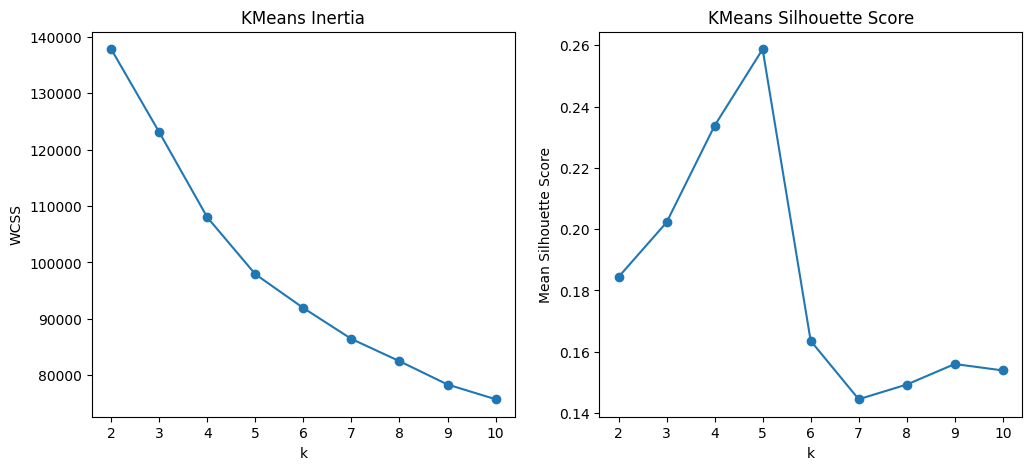

In [16]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(list(k_range), inertias, marker='o')
plt.xlabel('k')
plt.ylabel('WCSS')
plt.title('KMeans Inertia')

plt.subplot(1,2,2)
plt.plot(list(k_range), silhouettes, marker='o')
plt.xlabel('k')
plt.ylabel('Mean Silhouette Score')
plt.title('KMeans Silhouette Score')
plt.show()

In [20]:
elite_clustered_df, scaler, km = cluster_styles(elite_style_vectors, n_clusters=5)

print("Players per cluster:")
print(elite_clustered_df['cluster'].value_counts())

Players per cluster:
cluster
4    8621
3    2448
0    2047
1    1687
2    1429
Name: count, dtype: int64


## Find a User's Top Style Matching Neighbors 

In [26]:
USERNAME  = "Chessanonymous1"

In [31]:
def find_style_neighbors(
    user_vector: pd.Series,
    style_vectors: pd.DataFrame,
    scaler: StandardScaler,
    top_n: int = 5,
    exclude_player: Optional[str] = None,  
) -> pd.DataFrame:
    feats = style_vectors.drop(columns=["player", "cluster"], errors="ignore")

    user_vec_ordered = user_vector.reindex(feats.columns)

    user_arr = scaler.transform([user_vec_ordered.values])
    peer_arr = scaler.transform(feats)
    dists = pairwise_distances(user_arr, peer_arr, metric="euclidean")[0]
    out = style_vectors[["player"]].copy()
    out["distance"] = dists

    if exclude_player is not None:
        out = out[out["player"] != exclude_player]

    return out.nsmallest(top_n, "distance").reset_index(drop=True)

In [32]:
top_neighbors = find_style_neighbors(
    user_style_series, elite_clustered_df, scaler, top_n=5, exclude_player=USERNAME
)

print("Top 5 stylistic peers:")
display(top_neighbors)

Top 5 stylistic peers:


/Users/nicholasvega/Library/Caches/pypoetry/virtualenvs/chess-opening-recommender-LtfoShBY-py3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


,player,distance
0,b31b6Consultant,0.841804
1,fsalguero,1.028648
2,Sakh_chess_2,1.040547
3,AAlmeidaTX,1.066430
4,Recobachess,1.073688


In [33]:
peer_list = top_neighbors["player"].tolist()
peer_list

['b31b6Consultant', 'fsalguero', 'Sakh_chess_2', 'AAlmeidaTX', 'Recobachess']